# Regresión Lineal con Random Forest

En este cuaderno modelizamos la diferencia del porcentaje de voto entre PP y PSOE en las elecciones de abril de 2019, mediante un modelo de random forest en regresión. 

El proceso será el común a otros modelos: definición de la columnas objetivo, separación y tratamiento por separado de los dataset train y test, y modelización. Ajustaremos el modelo con todas las columnas disponibles o solo con las más importantes.

Comenzamos por la carga de librerías necesarias, así como del dataset de las elecciones de abril 2019.

##Definición de la variable objetivo

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [ ]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str'}

In [ ]:
df_eleccion = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/gen_A19_unif_cols_prov.txt', dtype = strings)

In [ ]:
df_eleccion

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,022019041010400101001,01,04,04001,400101001,Andalucía,Almería,Abla,1014,768,0.757396,5,763,9,754,149,326,131,44,0,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,73,80,89,81,94,87,91,77,72,42,67,56,19,4,0,1249,635,614,0.269816,0.590072,0.140112,291.0,0.243986,0.232986,143.0,0.419580,0.559441,0.329493,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 149, 'PSOE': 326, 'Cs': 131, 'UP': 44, ...","[('PSOE', 326), ('PP', 149), ('Cs', 131), ('VO..."
1,022019041010400201001,01,04,04002,400201001,Andalucía,Almería,Abrucena,1039,798,0.768046,6,792,7,785,127,380,91,60,0,113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,...,60,75,70,70,108,101,99,86,61,64,61,46,14,2,1,1202,637,565,0.278702,0.609817,0.111481,323.0,0.238390,0.268719,158.0,0.367089,0.601266,0.328482,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 127, 'PSOE': 380, 'Cs': 91, 'UP': 60, '...","[('PSOE', 380), ('PP', 127), ('VOX', 113), ('C..."
2,022019041010400301001,01,04,04003,400301001,Andalucía,Almería,Adra,671,519,0.773472,4,515,1,514,162,131,68,44,0,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,...,54,54,54,61,82,75,67,48,37,40,26,15,3,1,0,892,435,457,0.190583,0.643498,0.165919,7571.0,0.393871,8.487668,3036.0,0.399868,0.459157,0.286226,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 162, 'PSOE': 131, 'Cs': 68, 'UP': 44, '...","[('PP', 162), ('PSOE', 131), ('VOX', 103), ('C..."
3,022019041010400301002,01,04,04003,400301002,Andalucía,Almería,Adra,1282,954,0.744150,13,941,7,934,239,241,166,62,0,218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,...,108,158,162,150,140,119,103,67,49,37,30,14,7,1,0,1752,865,887,0.117009,0.647260,0.235731,7571.0,0.393871,4.321347,3036.0,0.399868,0.459157,0.286226,8599.0,7941.0,25677.0,23400.0,5381.0,4837.0,1815.0,1724.0,343.0,464.0,"{'PP': 239, 'PSOE': 241, 'Cs': 166, 'UP': 62, ...","[('PSOE', 241), ('PP', 239), ('VOX', 218), ('C..."
4,022019041010400301003,01,04,04003,400301003,Andalucía,Almería,Adra,1535,1087,0.708143,20,1067,6,1061,274,252,170,67,0,282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,4,...,189,178,215,227,164,110,96,61,58,41,40,27,4,4,0,2240,1094,1146,0.104911,0.647768,0.247321,7571.0,0.393871,3.379911,3036.0,0.399868,0.459157,0.286226,8076.0,7150.0,22051.0,19687.0,5224.0,4044.0,1170.0,1198.0,416.0,476.0,"{'PP': 274, 'PSOE': 252, 'Cs': 170, 'UP': 67, ...","[('VOX', 282), ('PP', 274), ('PSOE', 252), ('C..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36312,022019041195200108011,19,52,52001,5200108011,Melilla,Melilla,Melilla,1605,1118,0.696573,9,1109,4,1105,250,194,168,38,0,167,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,288,...,181,185,171,164,165,180,155,97,38,34,19,16,4,3,0,2480,1244,1236,0.085081,0.623387,0.291532,24290.0,0.193413,9.794355,11827.0,0.381331,0.398326,0.327464,16433.0,15847.0,66352.0,62632.0,11378.0,11119.0,1508.0,1274.0,167.0,166.0,"{'PP': 250, 'PSOE': 194, 'Cs': 168, 'UP': 38, ...","[(

In [ ]:
df_eleccion.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Definimos nuestra columna objetivo como diferencia entre las de porcentaje del PSOE y del PP. Como es conocido, la diferencia entre ambos fue de unos 11 puntos.

In [ ]:
df_eleccion['diff PSOE-PP'] = df_eleccion['% PSOE'] - df_eleccion['% PP']

In [ ]:
df_eleccion['diff PSOE-PP'].describe()

count    36315.000000
mean         0.102604
std          0.164478
min         -1.000000
25%          0.019355
50%          0.117730
75%          0.203527
max          0.920434
Name: diff PSOE-PP, dtype: float64

Solo hay dos filas que no tienen definida la columna objetivo.

In [ ]:
df_eleccion['diff PSOE-PP'].isna().sum()

2

In [ ]:
df_eleccion.loc[df_eleccion['diff PSOE-PP'].isna()]

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,diff PSOE-PP
10568,022019041063907502007,06,39,39075,3907502007,Cantabria,Cantabria,Santander,685,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,64,73,56,64,63,56,59,55,38,43,29,10,3,3,882,385,497,0.272109,0.574830,0.153061,91873.0,0.105613,104.164399,14572.0,0.452443,0.535479,0.136897,12844.0,12948.0,30563.0,30188.0,8117.0,7790.0,5171.0,5126.0,232.0,287.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0...","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),...",NaN
14870,022019041083735701001,08,37,37357,3735701001,Castilla - La Mancha,Salamanca,Villar de Ciervo,258,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,11,11,10,20,26,18,13,26,24,26,29,12,3,1,277,146,131,0.483755,0.462094,0.054152,44.0,0.681818,0.158845,14.0,0.428571,0.714286,0.241379,9536.0,8848.0,18599.0,18138.0,3933.0,3281.0,5148.0,4190.0,163.0,261.0,"{'PP': 0, 'PSOE': 0, 'Cs': 0, 'UP': 0, 'IU': 0...","[('PP', 0), ('PSOE', 0), ('Cs', 0), ('UP', 0),...",NaN


Hacemos una serie de plots de los porcentajes de ambos partidos y su diferencia.

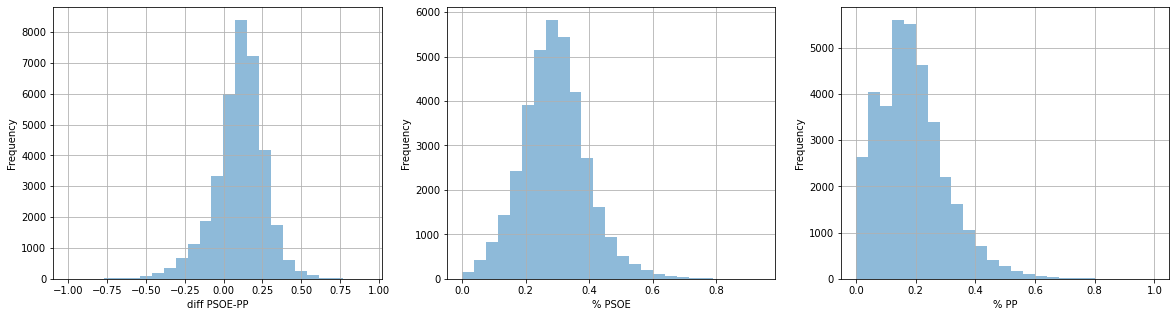

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1,3,1)
df_eleccion['diff PSOE-PP'].plot.hist(alpha=0.5, bins=25, grid = True)
#plt.axis([0, 10, 0, 10000])
plt.xlabel('diff PSOE-PP')

plt.subplot(1,3,2)
df_eleccion['% PSOE'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PSOE')

plt.subplot(1,3,3)
df_eleccion['% PP'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('% PP')

plt.show()

In [ ]:
df_eleccion['PSOE'].sum()

7481667

In [ ]:
df_eleccion.describe()

,cod_sec,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,% PP,% PSOE,% UP,% Vox,% Cs,% IU,0-4,...,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP
count,3.631700e+04,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.0,36317.000000,36317.0,36317.0,36317.0,36317.000000,36317.000000,36317.0,36317.0,36317.000000,36317.000000,36317.0,36317.000000,36317.0,36317.0,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36315.000000,36315.000000,36315.000000,36315.000000,36315.000000,36315.0,36317.000000,...,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,36317.000000,3.627100e+04,36271.000000,36271.000000,36303.000000,36303.000000,36303.000000,36271.000000,36178.000000,36178.000000,36178.000000,36178.000000,34041.000000,34041.000000,34041.000000,34041.000000,34041.000000,34041.000000,36315.000000
mean,2.566376e+09,958.261117,725.824903,0.758828,7.581408,718.243495,5.482749,712.760746,122.912851,206.010050,113.907674,103.239089,0.0,73.707134,0.0,0.0,0.0,27.964645,13.715533,0.0,0.0,10.867665,7.127461,0.0,3.778258,0.0,0.0,2.583170,1.436132,0.611614,4.761021,8.971886,11.166561,0.188463,0.291067,0.136721,0.102196,0.151376,0.0,56.135226,...,70.665556,78.761737,96.169838,110.514800,105.155189,100.169067,89.956467,77.074400,66.051574,59.912438,44.553212,37.277694,26.853732,11.442245,2.852851,0.448908,1294.881405,634.480491,660.400914,0.222335,0.600481,0.177183,2.150336e+05,0.230943,173.219401,28027.931493,0.428061,0.528475,0.210434,11505.018739,10869.106348,29477.534003,28020.872928,8314.100367,7306.835867,3178.389679,2940.963073,289.498314,346.348407,0.102604
std,1.436807e+09,437.906979,344.834412,0.073586,6.115915,341.724321,4.412176,339.188435,87.894068,112.301806,82.379609,68.731923,0.0,59.657869,0.0,0.0,0.0,82.872402,46.136236,0.0,0.0,55.301269,36.134619,0.0,24.598082,0.0,0.0,12.183276,14.238636,6.648651,19.875036,7.112796,18.314118,0.114328,0.102823,0.061077,0.060154,0.065176,0.0,45.273236,...,41.224067,49.876737,66.621546,75.273439,65.453286,55.428526,46.961287,41.709315,38.432323,36.645395,26.556226,21.207614,16.397375,8.493468,2.887382,0.832193,653.478204,326.033879,330.748408,0.095902,0.054204,0.060463,5.192026e+05,0.157414,446.946651,56141.160612,0.091417,0.097089,0.103300,3650.026093,3530.809436,10092.134163,9698.750682,3576.994175,3383.289953,1401.570239,1250.000095,119.816182,118.278271,0.164478
min,1.001010e+08,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.00

##Dataset de Train

Y no hay que hacer nada más antes de dividir el dataset entre train y test, y nos quedamos con el de train.

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_eleccion, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/train_set_RF_dif_PP_PSOE.txt', index=False)
test.to_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/test_set_RF_dif_PP_PSOE.txt', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 

df_train = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/train_set_RF_dif_PP_PSOE.txt',  dtype = strings)

Dimensiones del dataset de training: (29053, 98)
Dimensiones del dataset de test: (7264, 98)


In [ ]:
df_train

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,diff PSOE-PP
0,022019041113605701001,11,36,36057,3605701001,Extremadura,Pontevedra,Vigo,790,607,0.768354,11,596,4,592,95,230,72,135,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,13,3,...,82,83,83,73,62,56,56,86,43,40,33,12,3,0,1037,485,552,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,9681.0,24932.0,23853.0,6997.0,5506.0,3853.0,4029.0,325.0,399.0,"{'PP': 95, 'PSOE': 230, 'Cs': 72, 'UP': 135, '...","[('PSOE', 230), ('UP', 135), ('PP', 95), ('Cs'...",0.226510
1,022019041122801303008,12,28,28013,2801303008,Galicia,Madrid,Aranjuez,1237,878,0.709782,8,870,13,857,135,238,181,143,0,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,13,...,45,84,128,154,114,112,60,51,37,48,66,43,17,3,1502,699,803,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,11003.0,38245.0,36290.0,11471.0,9729.0,2131.0,1914.0,243.0,281.0,"{'PP': 135, 'PSOE': 238, 'Cs': 181, 'UP': 143,...","[('PSOE', 238), ('Cs', 181), ('UP', 143), ('PP...",0.118391
2,022019041071910301001,07,19,19103,1910301001,Castilla y León,Guadalajara,Checa,251,218,0.868526,2,216,1,215,65,90,19,12,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,23,18,16,19,33,19,20,16,17,18,17,9,1,0,282,172,110,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,10383.0,23170.0,20407.0,9044.0,6751.0,3908.0,3371.0,176.0,230.0,"{'PP': 65, 'PSOE': 90, 'Cs': 19, 'UP': 12, 'IU...","[('PSOE', 90), ('PP', 65), ('VOX', 28), ('Cs',...",0.115741
3,022019041100601201002,10,06,06012,601201002,C. Valenciana,Badajoz,Arroyo de San Serván,1011,794,0.785361,7,787,4,783,122,431,81,60,0,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,...,83,76,67,101,101,73,51,60,56,38,34,9,5,0,1237,629,608,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,6773.0,17583.0,17611.0,3733.0,2949.0,1957.0,2096.0,719.0,670.0,"{'PP': 122, 'PSOE': 431, 'Cs': 81, 'UP': 60, '...","[('PSOE', 431), ('PP', 122), ('VOX', 82), ('Cs...",0.392630
4,022019041011400501003,01,14,14005,1400501003,Andalucía,Córdoba,Almodóvar del Río,758,543,0.716359,15,528,7,521,76,185,80,130,0,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3,...,78,64,64,84,63,47,41,32,36,26,30,8,1,0,951,455,496,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,7094.0,19859.0,18347.0,5392.0,4172.0,2168.0,2158.0,616.0,653.0,"{'PP': 76, 'PSOE': 185, 'Cs': 80, 'UP': 130, '...","[('PSOE', 185), ('UP', 130), ('Cs', 80), ('PP'...",0.206439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,022019041092521704001,09,25,25217,2521704001,Cataluña,Lérida,Tàrrega,560,389,0.694643,1,388,5,383,16,43,29,27,0,9,0,0,0,129,115,0,0,0,0,0,0,0,0,0,0,0,0,4,11,...,83,69,38,63,72,61,54,30,16,27,19,16,7,0,920,438,482,0.183696,0.621739,0.194565,6412.0,0.209607,6.969565,1228.0,0.383550,0.506515,0.160733,10904.0,11208.0,27543.0,25572.0,7230.0,6682.0,3238.0,3392.0,269.0,271.

In [ ]:
cols_iniciales = df_train.columns

In [ ]:
cols_iniciales

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

Nos quedamos con las columnas que utilizaremos, que no incluyen las de voto o porcentaje de voto a los partidos, pues queremos ver la relación de las columnas socioeconómicas con la objetivo.

In [ ]:
cols_validas = ['CCAA',
        'Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'diff PSOE-PP']

In [ ]:
df_train = df_train[cols_validas]

In [ ]:
df_train

,CCAA,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP
0,Extremadura,790,0.768354,42,50,39,48,42,56,48,82,83,83,73,62,56,56,86,43,40,33,12,3,0,1037,485,552,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,9681.0,24932.0,23853.0,6997.0,5506.0,3853.0,4029.0,325.0,399.0,0.226510
1,Galicia,1237,0.709782,42,45,83,115,101,69,85,45,84,128,154,114,112,60,51,37,48,66,43,17,3,1502,699,803,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,11003.0,38245.0,36290.0,11471.0,9729.0,2131.0,1914.0,243.0,281.0,0.118391
2,Castilla y León,251,0.868526,5,5,7,9,4,7,19,23,18,16,19,33,19,20,16,17,18,17,9,1,0,282,172,110,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,10383.0,23170.0,20407.0,9044.0,6751.0,3908.0,3371.0,176.0,230.0,0.115741
3,C. Valenciana,1011,0.785361,60,58,54,53,77,90,91,83,76,67,101,101,73,51,60,56,38,34,9,5,0,1237,629,608,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,6773.0,17583.0,17611.0,3733.0,2949.0,1957.0,2096.0,719.0,670.0,0.392630
4,Andalucía,758,0.716359,54,54,58,50,40,67,54,78,64,64,84,63,47,41,32,36,26,30,8,1,0,951,455,496,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,7094.0,19859.0,18347.0,5392.0,4172.0,2168.0,2158.0,616.0,653.0,0.206439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,Cataluña,560,0.694643,40,44,55,40,63,54,69,83,69,38,63,72,61,54,30,16,27,19,16,7,0,920,438,482,0.183696,0.621739,0.194565,6412.0,0.209607,6.969565,1228.0,0.383550,0.506515,0.160733,10904.0,11208.0,27543.0,25572.0,7230.0,6682.0,3238.0,3392.0,269.0,271.0,0.069588
29049,Navarra,561,0.814617,36,58,52,52,39,48,29,56,72,79,61,32,25,43,23,19,17,9,0,0,0,750,365,385,0.148000,0.588000,0.264000,220555.0,0.135699,294.073333,40847.0,0.402184,0.479448,0.156261,9491.0,8590.0,26916.0,24345.0,7627.0,6765.0,2071.0,1782.0,227.0,289.0,0.061538
29050,Murcia,513,0.807018,17,11,13,19,25,20,24,34,34,49,47,43,42,33,55,46,24,30,14,3,0,583,261,322,0.351630,0.545455,0.102916,12349.0,0.196696,21.181818,5768.0,0.445735,0.480583,0.318375,16267.0,15427.0,35715.0,35879.0,NaN,NaN,NaN,NaN,NaN,NaN,0.056235
29051,Cataluña,1041,0.669549,134,118,124,75,108,106,123,188,182,136,121,100,106,94,72,58,48,27,10,6,1,1937,983,954,0.163139,0.604027,0.232834,14852.0,0.151697,7.667527,2746.0,0.483248,0.520393,0.156040,8499.0,8229.0,24419.0,23679.0,5903.0,5285.0,2392.0,2558.0,318.0,405.0,0.204942


In [ ]:
df_train.dtypes

CCAA                                 object
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

In [ ]:
df_train.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.901900e+04,29019.000000,29019.000000,29042.000000,29042.000000,29042.000000,29019.000000,28927.000000,28927.000000,28927.000000,28927.000000,27207.000000,27207.000000,27207.000000,27207.00000,27207.000000,27207.000000,29051.000000
mean,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.01193,289.773974,346.626932,0.103362
std,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.163886e+05,0.158011,445.088345,55886.671589,0.091630,0.096999,0.103397,3636.000670,3514.183923,10045.065165,9649.670139,3545.583225,3353.678770,1403.171191,1249.94899,119.433969,117.927213,0.165031
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.00000,71.000000,81.000000,-1.000000
25%,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.845000e+03,0.121701,1.320845,573.000000,0.398112,0.488372,0.138889,9092.000000,8508.500000,23195.500000,21899.000000,5966.500000,5045.000000,2208.000000,2071.00000,216.000000,275.000000,0.020625
50%,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.431700e+04,0.179074,9.809769,4240.000000,0.421271,0.525886,0.192784,10905.000000,10269.000000,27569.000000,26156.000000,7703.000000,6725.000000,2992.000000,2782.00000,269.000000,335.000000,0.118545
75%,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.000000,0.272635,0.633694,0.212171,9.949500e+04,0.280890,80.752151,22481.000000,0

Ahora toca rellenar los registros que son nan, que, por otra parte, no son muchos. Lo hacemos mediante la media de la columna.

In [ ]:
FillNA_num_mean = ['Censo_Esc', 'Participación',
        '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [ ]:
for item in FillNA_num_mean:
        
    df_train[item].fillna(df_train[item].mean(), inplace=True)

In [ ]:
df_train.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.905300e+04,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29051.000000
mean,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.011930,289.773974,346.626932,0.103362
std,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.160863e+05,0.157919,444.827822,55876.090363,0.091613,0.096981,0.103336,3628.107342,3506.555045,10023.258516,9628.721846,3431.089234,3245.381758,1357.859980,1209.585631,115.577207,114.119107,0.165031
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-1.000000
25%,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.846000e+03,0.121701,1.325815,574.000000,0.398112,0.488397,0.138930,9099.000000,8517.000000,23213.000000,21918.000000,6082.000000,5159.000000,2265.000000,2121.000000,220.000000,280.000000,0.020625
50%,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.434400e+04,0.179083,9.850248,4240.000000,0.421271,0.525926,0.192784,10924.000000,10286.000000,27618.000000,26199.000000,7855.336603,6845.948425,3110.000000,2889.000000,277.000000,343.000000,0.118545
75%,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.000000,0.272635,0.633694,0.212171,9.949500e+04,0.280792,81.265306,22481.00

Ahora tomamos la única columna categórica, la CCAA, y la transformamos en numérica mediante el algoritmo means.

In [ ]:
categorical = ['CCAA']

In [ ]:
df_train['CCAA'].value_counts().sum()

29053

In [ ]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_train.groupby(c)['diff PSOE-PP'].mean()
    df_train[c] = df_train[c].map(mean)    
    mean_map1[c] = mean

In [ ]:
mean_map1

{'CCAA': CCAA
 'Islas Baleares'        0.094335
 Andalucía               0.180661
 Aragón                  0.102254
 Asturias                0.153087
 C. Valenciana           0.171299
 Canarias                0.128334
 Cantabria               0.032048
 Castilla - La Mancha   -0.043416
 Castilla y León         0.084026
 Cataluña                0.181926
 Ceuta                   0.179790
 Extremadura             0.036303
 Galicia                 0.097164
 La Rioja                0.091570
 Madrid                 -0.046086
 Melilla                -0.002583
 Murcia                  0.122695
 Navarra                 0.012145
 País Vasco             -0.001337
 Name: diff PSOE-PP, dtype: float64}

In [ ]:
df_train.dtypes

CCAA                                float64
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

In [ ]:
df_train.describe()

,CCAA,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP
count,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,2.905300e+04,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29053.000000,29051.000000
mean,0.103354,956.698620,0.758225,55.979555,64.732041,68.540977,63.875916,63.430145,70.589061,78.593157,95.926686,110.241145,104.983651,100.020067,89.869411,77.090146,66.079441,59.869239,44.541218,37.272846,26.805390,11.435687,2.848794,0.450418,1293.174991,633.628610,659.546381,0.222423,0.600480,0.177097,2.131663e+05,0.231285,171.994358,27899.223504,0.428165,0.528409,0.210673,11481.390398,10848.000703,29414.936055,27967.754271,8283.665447,7277.752872,3176.861782,2939.011930,289.773974,346.626932,0.103362
std,0.072711,437.769889,0.073920,44.964268,50.275843,49.716201,42.149367,37.507779,40.991249,49.409638,66.171139,75.117674,65.310899,55.332556,47.021672,41.950023,38.688731,36.909974,26.703108,21.331781,16.436542,8.548030,2.893223,0.835001,653.981388,325.959982,331.175161,0.095884,0.054285,0.060523,5.160863e+05,0.157919,444.827822,55876.090363,0.091613,0.096981,0.103336,3628.107342,3506.555045,10023.258516,9628.721846,3431.089234,3245.381758,1357.859980,1209.585631,115.577207,114.119107,0.165031
min,-0.046086,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-1.000000
25%,0.084026,690.000000,0.719570,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,431.000000,462.000000,0.159597,0.572816,0.143734,1.846000e+03,0.121701,1.325815,574.000000,0.398112,0.488397,0.138930,9099.000000,8517.000000,23213.000000,21918.000000,6082.000000,5159.000000,2265.000000,2121.000000,220.000000,280.000000,0.020625
50%,0.097164,952.000000,0.765988,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,610.000000,650.000000,0.211869,0.605886,0.176874,1.434400e+04,0.179083,9.850248,4240.000000,0.421271,0.525926,0.192784,10924.000000,10286.000000,27618.000000,26199.000000,7855.336603,6845.948425,3110.000000,2889.000000,277.000000,343.000000,0.118545
75%,0.180661,1239.000000,0.807240,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,825.000000,860.0

Ahora vemos las columnas que están correlacionadas entre sí.

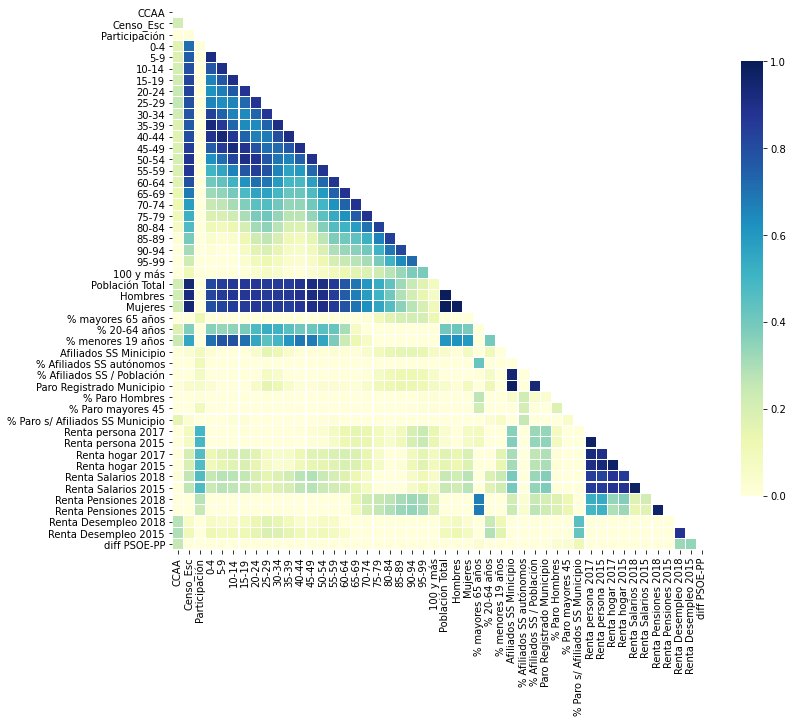

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_train).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Vemos que la las edades y las rentas estan correlacionadas entre sí. También se observa que la columna objetivo esta bastante relacionada con la CCAA y las rentas de desempleo.

In [ ]:
df_train.columns

Index(['CCAA', 'Censo_Esc', 'Participación', '0-4', '5-9', '10-14', '15-19',
       '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
       '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99',
       '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015',
       'diff PSOE-PP'],
      dtype='object')

Eliminamos una serie de columnas que hemos visto que están demasiado correlacionadas con otras.

In [ ]:
df_train = df_train.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_train

,CCAA,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018,diff PSOE-PP
0,0.036303,790,0.768354,42,50,39,48,42,56,48,82,83,83,73,62,56,56,86,43,40,33,12,3,0,1037,0.263259,0.564127,0.172613,137835.0,0.132564,132.917068,30079.0,0.433292,0.539346,0.179133,10249.0,24932.0,6997.000000,3853.000000,325.000000,0.226510
1,0.097164,1237,0.709782,42,45,83,115,101,69,85,45,84,128,154,114,112,60,51,37,48,66,43,17,3,1502,0.216378,0.593875,0.189747,14994.0,0.186675,9.982690,5180.0,0.406757,0.490927,0.256766,11968.0,38245.0,11471.000000,2131.000000,243.000000,0.118391
2,0.084026,251,0.868526,5,5,7,9,4,7,19,23,18,16,19,33,19,20,16,17,18,17,9,1,0,282,0.347518,0.560284,0.092199,59.0,0.610169,0.209220,17.0,0.647059,0.470588,0.223684,11882.0,23170.0,9044.000000,3908.000000,176.000000,0.115741
3,0.171299,1011,0.785361,60,58,54,53,77,90,91,83,76,67,101,101,73,51,60,56,38,34,9,5,0,1237,0.204527,0.613581,0.181892,1483.0,0.226568,1.198868,707.0,0.373409,0.514851,0.322831,7174.0,17583.0,3733.000000,1957.000000,719.000000,0.392630
4,0.180661,758,0.716359,54,54,58,50,40,67,54,78,64,64,84,63,47,41,32,36,26,30,8,1,0,951,0.182965,0.589905,0.227129,2119.0,0.181218,2.228181,1490.0,0.393960,0.522819,0.412857,7646.0,19859.0,5392.000000,2168.000000,616.000000,0.206439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29048,0.181926,560,0.694643,40,44,55,40,63,54,69,83,69,38,63,72,61,54,30,16,27,19,16,7,0,920,0.183696,0.621739,0.194565,6412.0,0.209607,6.969565,1228.0,0.383550,0.506515,0.160733,10904.0,27543.0,7230.000000,3238.000000,269.000000,0.069588
29049,0.012145,561,0.814617,36,58,52,52,39,48,29,56,72,79,61,32,25,43,23,19,17,9,0,0,0,750,0.148000,0.588000,0.264000,220555.0,0.135699,294.073333,40847.0,0.402184,0.479448,0.156261,9491.0,26916.0,7627.000000,2071.000000,227.000000,0.061538
29050,0.122695,513,0.807018,17,11,13,19,25,20,24,34,34,49,47,43,42,33,55,46,24,30,14,3,0,583,0.351630,0.545455,0.102916,12349.0,0.196696,21.181818,5768.0,0.445735,0.480583,0.318375,16267.0,35715.0,8283.665447,3176.861782,289.773974,0.056235
29051,0.181926,1041,0.669549,134,118,124,75,108,106,123,188,182,136,121,100,106,94,72,58,48,27,10,6,1,1937,0.163139,0.604027,0.232834,14852.0,0.151697,7.667527,2746.0,0.483248,0.520393,0.156040,8499.0,24419.0,5903.000000,2392.000000,318.000000,0.204942


Nos quedamos con las filas que tienen definido la columna objetivo.

In [ ]:
df_train = df_train[df_train['diff PSOE-PP'].notnull()]

In [ ]:
df_train.describe()

,CCAA,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta hogar 2017,Renta Salarios 2018,Renta Pensiones 2018,Renta Desempleo 2018,diff PSOE-PP
count,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,2.905100e+04,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000,29051.000000
mean,0.103362,956.732023,0.758278,55.982479,64.734777,68.544525,63.878971,63.432687,70.592338,78.596365,95.930708,110.245844,104.988606,100.024061,89.872535,77.092906,66.081512,59.870572,44.542150,37.273037,26.805239,11.435716,2.848783,0.450312,1293.224123,0.222412,0.600486,0.177102,2.131779e+05,0.231274,172.002608,27900.642128,0.428164,0.528402,0.210675,11481.410459,29415.268844,8283.820944,3176.725289,289.780327,0.103362
std,0.072708,437.762861,0.073654,44.964365,50.276191,49.715989,42.148930,37.507505,40.990543,49.409669,66.171275,75.117685,65.310137,55.332065,47.021533,41.949852,38.688787,36.910698,26.703727,21.332387,16.437098,8.548319,2.893323,0.834889,653.972272,0.095874,0.054281,0.060520,5.161021e+05,0.157900,444.841814,55877.719533,0.091616,0.096978,0.103339,3628.205470,10023.400398,3431.112249,1357.807059,115.578295,0.165031
min,-0.046086,3.000000,0.028986,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.142857,0.000000,2.000000e+00,0.000000,0.019417,0.000000,0.000000,0.000000,0.000000,3431.000000,12087.000000,1767.000000,345.000000,71.000000,-1.000000
25%,0.084026,690.000000,0.719617,28.000000,32.000000,35.000000,36.000000,39.000000,44.000000,48.000000,55.000000,63.000000,63.000000,64.000000,60.000000,51.000000,42.000000,38.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,897.000000,0.159597,0.572820,0.143734,1.846500e+03,0.121701,1.325825,575.000000,0.398112,0.488397,0.138930,9098.500000,23213.500000,6082.500000,2265.000000,220.000000,0.020625
50%,0.097164,952.000000,0.765996,47.000000,54.000000,58.000000,57.000000,60.000000,68.000000,73.000000,85.000000,97.000000,95.000000,94.000000,86.000000,73.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1262.000000,0.211864,0.605888,0.176875,1.434400e+04,0.179083,9.850248,4240.000000,0.421271,0.525886,0.192784,10924.000000,27618.000000,7855.336603,3110.000000,277.000000,0.118545
75%,0.180661,1239.500000,0.807251,73.000000,86.000000,93.000000,86.000000,85.000000,94.000000,103.000000,125.000000,144.000000,138.000000,131.000000,117.000000,101.000000,86.000000,78.000000,59.000000,50.000000,36.000000,16.000000,4.000000,1.000000,1682.000000,0.272622,0.633695,0.212172,9.949500e+04,0.280792,81.254779,22481.000000,0.442646,0.547041,0.274113,12919.000000,32792.500000,9546.500000,3800.000000,322.000000,0.204136
max,0.181926,3480.000000,1.000000,650.000000,560.000000,468.000000,365.000000,362.000000,491.000000,647.000000,854.000000,918.000000,704.000000,718.000000,957.000000,1256.000000,1740.000000,2105.000000,1262.000000,591.000000,193.000000,145.000000,51.000000,20.000000,11747.000000,0.857143,1.000000,0.458289,1.996269e+06,1.000000,3355.073950,220332.000000,1.000000,1.000000,0.777778,30210.000000,86006.000000,26674.000000,8302.000000,846.000000,0.920434


Y ahora definimos el vector y y la matriz X del dataset train.

In [ ]:
y_train = df_train['diff PSOE-PP']

In [ ]:
y_train

0        0.226510
1        0.118391
2        0.115741
3        0.392630
4        0.206439
           ...   
29048    0.069588
29049    0.061538
29050    0.056235
29051    0.204942
29052    0.228608
Name: diff PSOE-PP, Length: 29051, dtype: float64

In [ ]:
X_train = df_train.drop(['diff PSOE-PP'], axis = 1)

In [ ]:
X_train.shape

(29051, 40)

In [ ]:
y_train.shape

(29051,)

##Dataset de Test

Pasamos ahora al dataset de test, al que aplicaremos los mismos procedimientos, y en el mismo orden, que al de train.

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Proyecto_KeepCoding - Propio/Data/Gen-19-Abr/test_set_RF_dif_PP_PSOE.txt',  dtype = strings)

In [ ]:
df_test

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,...,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord,diff PSOE-PP
0,022019041082408910003,08,24,24089,2408910003,Castilla - La Mancha,León,León,638,480,0.752351,8,472,4,468,105,151,82,61,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,9,...,49,71,55,55,66,41,38,45,25,52,38,17,5,0,783,335,448,0.280971,0.556833,0.162197,63898.0,0.128439,81.606641,11285.0,0.429154,0.528135,0.150100,11009.0,10229.0,23550.0,21824.0,6997.0,5837.0,4398.0,4420.0,177.0,253.0,"{'PP': 105, 'PSOE': 151, 'Cs': 82, 'UP': 61, '...","[('PSOE', 151), ('PP', 105), ('Cs', 82), ('UP'...",0.097458
1,022019041084718603004,08,47,47186,4718603004,Castilla - La Mancha,Valladolid,Valladolid,736,597,0.811141,0,597,9,588,130,159,131,81,0,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,4,...,54,76,90,75,61,65,39,42,43,38,19,17,4,0,911,394,517,0.221734,0.615807,0.162459,146297.0,0.113782,160.589462,24645.0,0.426375,0.532684,0.144172,12114.0,11259.0,27930.0,27039.0,9269.0,7373.0,3657.0,3545.0,207.0,197.0,"{'PP': 130, 'PSOE': 159, 'Cs': 131, 'UP': 81, ...","[('PSOE', 159), ('Cs', 131), ('PP', 130), ('UP...",0.048576
2,022019041053800601012,05,38,38006,3800601012,Canarias,Santa Cruz de Tenerife,Arona,875,504,0.576000,7,497,3,494,79,173,61,50,0,29,0,0,0,0,0,0,0,0,0,0,87,0,0,0,0,0,0,6,9,...,111,101,120,89,89,88,60,38,25,12,12,2,2,0,1282,639,643,0.117785,0.665367,0.216849,30637.0,0.185625,23.897816,8767.0,0.445991,0.514999,0.222490,7499.0,6930.0,22157.0,20318.0,5828.0,4892.0,1629.0,1396.0,447.0,574.0,"{'PP': 79, 'PSOE': 173, 'Cs': 61, 'UP': 50, 'I...","[('PSOE', 173), ('CC', 87), ('PP', 79), ('Cs',...",0.189135
3,022019041090801905042,09,08,08019,801905042,Cataluña,Barcelona,Barcelona,931,779,0.836735,0,779,9,770,80,135,163,51,0,50,0,0,0,148,121,0,0,0,0,0,0,0,0,0,0,0,0,7,15,...,107,88,67,94,81,76,56,56,53,52,41,22,6,1,1297,615,682,0.221280,0.596762,0.181958,1134047.0,0.108401,874.361604,87744.0,0.458413,0.535843,0.071816,21924.0,20374.0,51413.0,47815.0,15592.0,13968.0,4605.0,4711.0,146.0,203.0,"{'PP': 80, 'PSOE': 135, 'Cs': 163, 'UP': 51, '...","[('Cs', 163), ('ERC', 148), ('PSOE', 135), ('J...",0.070603
4,022019041010407902002,01,04,04079,407902002,Andalucía,Almería,Roquetas de Mar,1289,884,0.685803,3,881,11,870,210,225,135,82,0,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,9,...,238,222,188,148,122,100,71,65,31,24,9,5,2,0,2265,1196,1069,0.091391,0.657837,0.250773,29256.0,0.262955,12.916556,10769.0,0.436345,0.452410,0.269057,7199.0,6616.0,21454.0,19992.0,4799.0,3931.0,963.0,975.0,468.0,540.0,"{'PP': 210, 'PSOE': 225, 'Cs': 135, 'UP': 82, ...","[('PSOE', 225), ('PP', 210), ('VOX', 202), ('C...",0.017026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7259,022019041122807901087,12,28,28079,2807901087,Galicia,Madrid,Madrid,934,804,0.860814,4,800,4,796,229,177,200,69,0,109,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,...,124,108,94,127,84,70,46,51,38,25,25,15,3,1,1324,625,699,0.154079,0.700906,0.145015,1996269.0,0.096084,1507.756042,220332.0,0.442646,0.534126,0.099401,28839.0,28350.0,65532.0,6373

Tomamos las columnas que nos serán útiles...

In [ ]:
df_test = df_test[cols_validas]

...rellenamos los registros que son nan...

In [ ]:
for item in FillNA_num_mean:
        
    df_test[item].fillna(df_test[item].mean(), inplace=True)

In [ ]:
df_test.describe()

,Censo_Esc,Participación,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,diff PSOE-PP
count,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7.264000e+03,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000,7264.000000
mean,964.510463,0.761238,56.757847,65.368117,68.839482,64.242704,63.665611,70.971503,79.435986,97.142346,111.609306,105.841272,100.765006,90.304653,77.011426,65.940116,60.085215,44.601184,37.297081,27.047081,11.468475,2.869080,0.442869,1301.706360,637.887665,663.818695,0.221985,0.600487,0.177528,2.225054e+05,0.229574,178.121430,28542.727999,0.427643,0.528740,0.209475,11599.281185,10953.304803,29727.261056,28232.783478,8435.265551,7422.618868,3184.472424,2948.730812,288.400877,345.239563,0.099572
std,438.429341,0.072187,46.486400,50.355804,49.578011,42.145355,37.483447,42.143865,51.700767,68.389342,75.888578,66.019778,55.810565,46.720593,40.735139,37.391622,35.569481,25.962204,20.704981,16.239465,8.272174,2.864042,0.820894,651.462011,326.329489,329.036556,0.095981,0.053882,0.060227,5.298457e+05,0.154879,453.929190,57136.914978,0.090545,0.097431,0.102826,3700.887721,3592.163777,10265.472868,9881.109672,3586.070072,3391.461365,1353.331309,1212.689717,117.682122,116.071477,0.162221
min,6.000000,0.273438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,3.000000,2.000000,0.007463,0.200000,0.000000,2.000000e+00,0.000000,0.033898,0.000000,0.000000,0.000000,0.000000,3431.000000,3281.000000,12087.000000,11388.000000,1767.000000,1349.000000,345.000000,476.000000,71.000000,81.000000,-0.750000
25%,694.000000,0.722909,29.000000,33.000000,36.000000,36.000000,39.000000,45.000000,48.000000,56.000000,63.000000,63.000000,64.000000,60.000000,51.000000,43.000000,39.000000,28.000000,22.000000,15.000000,5.000000,1.000000,0.000000,908.750000,434.000000,468.000000,0.158919,0.572505,0.143781,2.001000e+03,0.121375,1.409837,600.750000,0.397611,0.490343,0.137186,9144.000000,8537.750000,23393.500000,22021.500000,6088.500000,5177.250000,2283.750000,2134.000000,216.000000,276.000000,0.015463
50%,955.000000,0.767973,48.000000,55.000000,59.000000,57.000000,60.000000,68.000000,73.000000,86.000000,98.000000,95.000000,95.000000,87.000000,74.000000,63.000000,57.000000,43.000000,36.000000,25.000000,10.000000,2.000000,0.000000,1260.000000,610.500000,651.000000,0.212198,0.605347,0.177567,1.382200e+04,0.179083,9.783425,4147.000000,0.420875,0.527070,0.192784,10985.000000,10363.500000,27625.000000,26131.500000,7855.336603,6845.948425,3124.500000,2916.000000,273.000000,339.000000,0.114376
75%,1251.250000,0.810201,74.000000,86.000000,92.000000,88.000000,85.000000,94.000000,104.000000,125.000000,144.000000,139.000000,132.000000,117.000000,100.000000,86.000000,78.000000,59.000000,50.000000,37.000000,16.000000,4.000000,1.000000,1691.000000,827.000000,865.000000,0.272616,0.633610,0.212706,1.008638e+05,0.280495,81.743621,20869.000000,0.442646,0.547409,0.272727,12990.250000,1

In [ ]:
df_test.dtypes

CCAA                                 object
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

...tratamos la columna categórica, CCAA...

In [ ]:
for c in categorical:
    df_test[c] = df_test[c].map(mean_map1[c])

In [ ]:
df_test.dtypes

CCAA                                float64
Censo_Esc                             int64
Participación                       float64
0-4                                   int64
5-9                                   int64
10-14                                 int64
15-19                                 int64
20-24                                 int64
25-29                                 int64
30-34                                 int64
35-39                                 int64
40-44                                 int64
45-49                                 int64
50-54                                 int64
55-59                                 int64
60-64                                 int64
65-69                                 int64
70-74                                 int64
75-79                                 int64
80-84                                 int64
85-89                                 int64
90-94                                 int64
95-99                           

In [ ]:
df_test['CCAA'].describe()

count    7264.000000
mean        0.102254
std         0.073004
min        -0.046086
25%         0.084026
50%         0.097164
75%         0.180661
max         0.181926
Name: CCAA, dtype: float64

...nos libramos de columnas demasiado correlacionadas...

In [ ]:
df_test = df_test.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [ ]:
df_test.shape

(7264, 41)

...así como de las filas que tienen nan en la columna objetivo.

In [ ]:
df_test = df_test[df_test['diff PSOE-PP'].notnull()]

Y ahora ya podemos definir el vector y y la matriz X, en este caso del dataset de test.

In [ ]:
y_test = df_test['diff PSOE-PP']

In [ ]:
X_test = df_test.drop(['diff PSOE-PP'], axis = 1)

In [ ]:
y_test.shape

(7264,)

In [ ]:
X_test.shape

(7264, 40)

Preparamos los vectores y matrices para aplicar SKlearn

In [ ]:
columnas = X_train.columns

In [ ]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

Antes del modelo, echamos un vistazo a la relevancia de las columnas, mediante los algos F-test y el Mutual Info.

In [ ]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [ ]:
y_train

array([0.22651007, 0.1183908 , 0.11574074, ..., 0.05623472, 0.20494186,
       0.22860792])

In [ ]:
y_test

array([0.09745763, 0.04857621, 0.18913481, ..., 0.11538462, 0.16114286,
       0.23684211])

##Relevancia de columnas

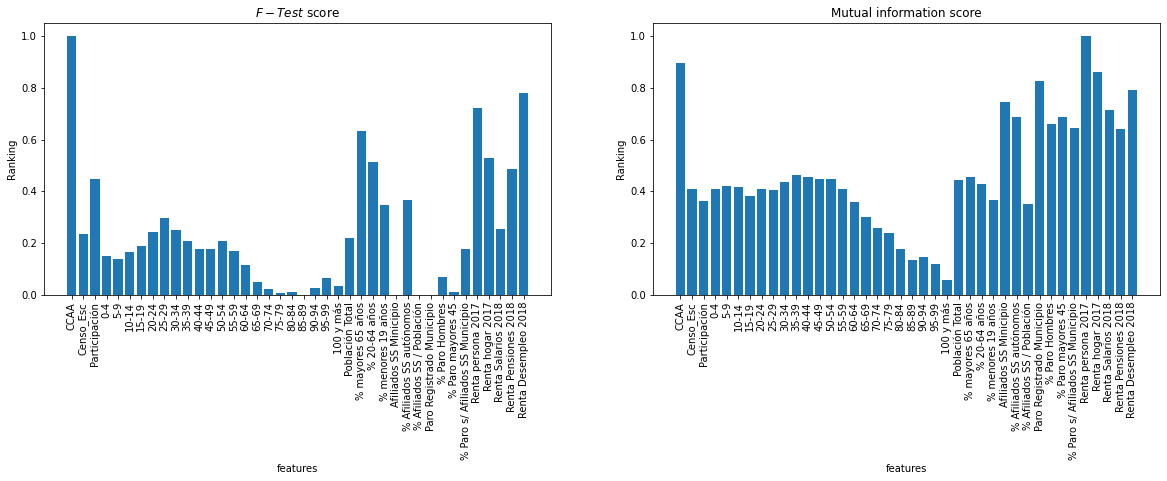

In [ ]:
y = y_train    # nos quedamos con la 1ª columna, price
X = X_train      # nos quedamos con el resto

feature_names = columnas


# do calculations
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]),f_test,  align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-Test$ score')

plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi, align="center")
plt.xticks(range(X.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

Vemos que las columnas más relevantes son las de la CCAA, así como otras de la renta y afiliados a la SS.

Almacenamos las más relevantes en un array, para utilizarlas después en el modelo.

In [ ]:
columnas_MI = columnas[mi > 0.45]

In [ ]:
columnas_MI

Index(['CCAA', '35-39', '40-44', '% mayores 65 años', 'Afiliados SS Minicipio',
       '% Afiliados SS autónomos', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta hogar 2017', 'Renta Salarios 2018', 'Renta Pensiones 2018',
       'Renta Desempleo 2018'],
      dtype='object')

In [ ]:
len(columnas_MI)

15

##Modelización con Random Forest

Cargamos las librerias del random forest regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

Comenzamos aplicando grid search para optimizar la profundidad del modelo. Vemos que no deja de aumentar el mean test score cuando llegamos a 17.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  7.1min finished


best mean cross-validation score: 0.611
best parameters: {'max_depth': 15}


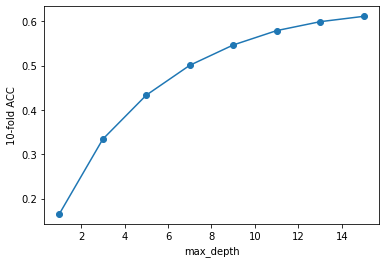

In [ ]:

# grid search
maxDepth = range(1,17,2)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), 
                    param_grid=tuned_parameters,cv=5, verbose = 1) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Probamos hasta llegar a 21, y sigue aumentando, pero ya muy poco a poco.

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.7min finished


best mean cross-validation score: 0.626
best parameters: {'max_depth': 21}


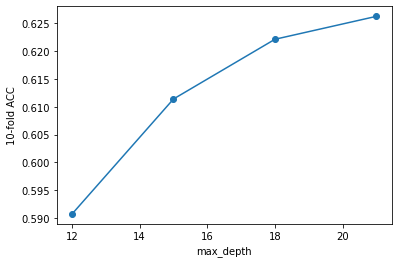

In [ ]:
maxDepth = range(12,24,3)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), 
                    param_grid=tuned_parameters,cv=5, verbose = 1) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

Como cabía esperar, con una profundidad de 21 obtenemos un score en train de 0,93 y de 0,64 en test, un overfitting de libro.

In [ ]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo, n_estimators=200, max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.9372522168238854
Test:  0.6480478274083342


Probamos una profundidad menor, de 9, y ya parece que no tenemos un gran overfitting.

In [ ]:
#maxDepthOptimo = grid.best_params_['max_depth']
maxDepthOptimo = 9

bagModel = RandomForestRegressor(max_depth=maxDepthOptimo, n_estimators=200, max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.6338279939032909
Test:  0.5642553227016238


In [ ]:
bagModel.feature_importances_

array([0.16682369, 0.0088188 , 0.02691739, 0.01295591, 0.01890725,
       0.01893478, 0.00918615, 0.01265918, 0.00867682, 0.01347953,
       0.0146926 , 0.01295279, 0.00763368, 0.00827672, 0.00920375,
       0.00663268, 0.00472792, 0.00501083, 0.00536898, 0.00493439,
       0.00458963, 0.00580971, 0.00529417, 0.00134987, 0.01487067,
       0.0445803 , 0.03055024, 0.0091024 , 0.0185202 , 0.02654871,
       0.01519362, 0.04812326, 0.0159349 , 0.01436155, 0.02126745,
       0.1125798 , 0.07142818, 0.03714137, 0.05645396, 0.06950617])

Podemos comprobar la importancia de las columnas en el modelo, y vemos de nuevo que las CCAA y las rentas son las más importantes, algo que ya habíamos visto en el mutual info.

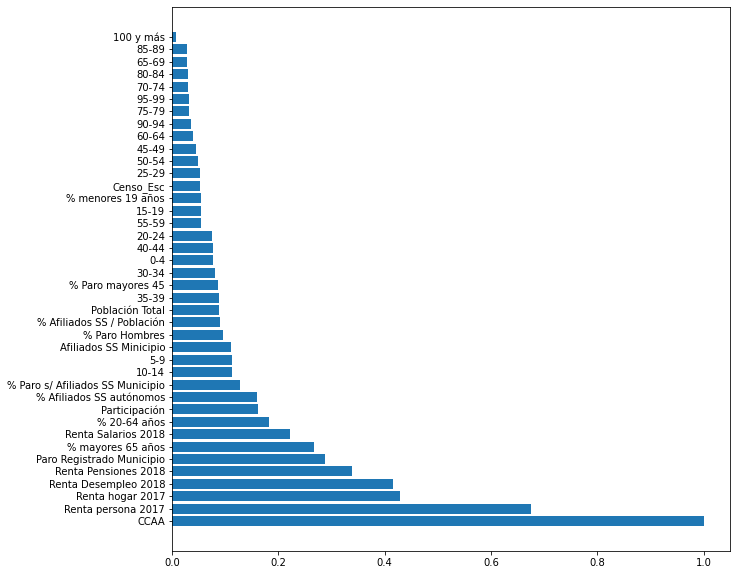

In [ ]:
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),columnas[indices])
plt.show()

Vamos a tomar pues solo las columnas con un coef de importancia superior a 0,2, que son ocho.

In [ ]:
cols_import = columnas[importances > 0.2]

In [ ]:
cols_import

Index(['CCAA', '% mayores 65 años', 'Paro Registrado Municipio',
       'Renta persona 2017', 'Renta hogar 2017', 'Renta Salarios 2018',
       'Renta Pensiones 2018', 'Renta Desempleo 2018'],
      dtype='object')

In [ ]:
len(cols_import)

8

Modificamos las matrices X de train y test, tomando solo estas 8 columnas.

In [ ]:
X_train = df_train[cols_import]

In [ ]:
X_train = X_train.values

In [ ]:
X_train.shape

(29051, 8)

In [ ]:
X_test = df_test[cols_import]

In [ ]:
X_test.shape

(7264, 8)

In [ ]:
X_test = X_test.values

Volvemos a probar con grid search con profundidad 1 a 15...

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

best mean cross-validation score: 0.588
best parameters: {'max_depth': 13}


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    8.2s finished


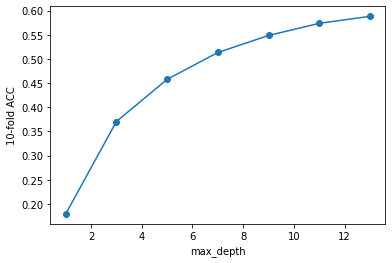

In [ ]:
maxDepth = range(1,15,2)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt', verbose = 1), 
                    param_grid=tuned_parameters,cv=5) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()

... y no vemos el máximo, pero como sabemos que si subimos la profundiad nos encontramos con overfitting, pues probamos con 15. Tenemos overfitting, aunque es cierto que menos intenso que tomando todas las columnas.

In [ ]:
maxDepthOptimo = grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo, n_estimators=200, max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.7420454555485281
Test:  0.6056054350583291


Lo mejor es quedarse con una profundidad menor, que pensamos que da unos resultados aceptables, para solo 8 columnas, y que desde luego no parece tener overfitting. El score para test es 0.56, igual que con más de 40 columnas, por lo que sin duda preferiríamos este modelo.

In [ ]:
# maxDepthOptimo = grid.best_params_['max_depth']
maxDepthOptimo = 9
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo, n_estimators=200, max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.6037311470141192
Test:  0.5657620306063147
